In [1]:
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.datasets import  mnist
from tensorflow.keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Reshape
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
img_rows = 28
img_cols = 28
channels =1

img_shape = (28, 28, 1)
z_dim = 100

In [3]:
def build_generator(z_dim):
  model = Sequential()
  model.add(Dense(256 * 7 * 7, input_dim = z_dim))
  model.add(Reshape((7,7,256)))

  model.add(Conv2DTranspose(128, kernel_size= 3, strides= 2, padding= 'same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha= 0.01))

  model.add(Conv2DTranspose(64, kernel_size= 3,strides=1 ,padding= 'same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha= 0.01))

  model.add(Conv2DTranspose(1, kernel_size= 3, strides= 2, padding='same'))
  model.add(Activation('tanh'))

  return model

In [4]:
def build_discriminator(img_shape):
  model = Sequential()

  model.add(Conv2D(32,
                   kernel_size = 3,
                   strides = 2,
                   input_shape = img_shape,
                   padding = 'same'))
  
  model.add(LeakyReLU(alpha= 0.01))

  model.add(Conv2D(64,
                   kernel_size = 3,
                   strides = 2,
                   padding = 'same'))
  
  model.add(LeakyReLU(alpha= 0.01))

  model.add(Conv2D(128,
                  kernel_size = 3,
                  strides = 2,
                  padding = 'same'))
  
  model.add(LeakyReLU(alpha= 0.01))

  model.add(Flatten())
  model.add(Dense(1, activation= 'sigmoid'))

  return model

In [5]:
def build_gan(generator, discriminator):
  model = Sequential()

  model.add(generator)
  model.add(discriminator)

  return model


discriminator = build_discriminator(img_shape)
generator = build_generator(z_dim)

discriminator.compile(loss = 'binary_crossentropy',
                      optimizer = Adam(),
                      metrics = ['accuracy'])
discriminator.trainable = False

gan = build_gan(generator, discriminator)
gan.compile(loss = 'binary_crossentropy', optimizer = Adam())

In [6]:
losses = []
accuracies = []
iteration_checkpoint = []

def train(iterations, batch_size, sample_interval):
  (X_train, _), (_, _) = mnist.load_data()

  X_train = X_train / 127.5 -1.0
  X_train = np.expand_dims(X_train, axis= 3)

  real = np.ones((batch_size, 1))
  fake = np.zeros((batch_size , 1))

  for iteration in range(iterations):
    
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]

    z = np.random.normal(0, 1, (batch_size, 100))
    gen_imgs = generator.predict(z)

    d_loss_real = discriminator.train_on_batch(imgs, real)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

    z = np.random.normal(0, 1, (batch_size, 100))
    gen_imgs = generator.predict(z)

    g_loss = gan.train_on_batch(z, real)
    if (iteration + 1) % sample_interval == 0:
      losses.append((d_loss, g_loss))
      accuracies.append(100.0 * accuracy)
      iteration_checkpoint.append(iteration + 1)

      print(f'iter : {iteration + 1}[D손실 : {d_loss}], [정확도 : {100.0 * accuracy}] [G손실 : {g_loss}]')

      sample_images(generator)

In [7]:
def sample_images(generator, image_grid_rows = 4, image_gird_columns = 4):
  z = np.random.normal(0, 1, (image_grid_rows * image_gird_columns, z_dim))

  gen_imgs = generator.predict(z)
  gen_imgs = 0.5 * gen_imgs + 0.5

  fig, axs = plt.subplots(image_grid_rows,
                          image_gird_columns,
                          figsize = (4,4),
                          sharex = True,
                          sharey = True)
  
  cnt = 0 
  for i in range(image_grid_rows):
    for j in range(image_gird_columns):
      axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap = 'gray')
      axs[i, j].axis('off')
      cnt += 1

  plt.show()

11493376/11490434 [==============================] - 0s 0us/step
iter : 1000[D손실 : 0.37185636162757874], [정확도 : 85.15625] [G손실 : 1.9909433126449585]


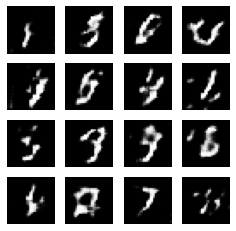

iter : 2000[D손실 : 0.31323233246803284], [정확도 : 87.5] [G손실 : 2.183596134185791]


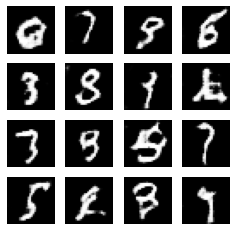

iter : 3000[D손실 : 0.3329976797103882], [정확도 : 87.109375] [G손실 : 2.328608989715576]


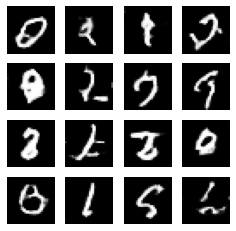

iter : 4000[D손실 : 0.5080073773860931], [정확도 : 79.296875] [G손실 : 2.322115421295166]


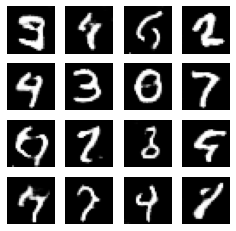

iter : 5000[D손실 : 0.5381263494491577], [정확도 : 75.390625] [G손실 : 1.987162470817566]


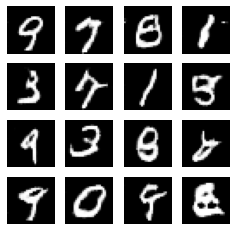

iter : 6000[D손실 : 0.3134361803531647], [정확도 : 85.15625] [G손실 : 2.1143813133239746]


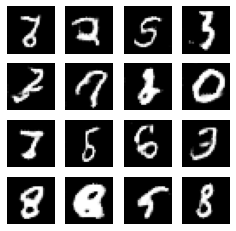

iter : 7000[D손실 : 0.42918939888477325], [정확도 : 79.6875] [G손실 : 2.049496650695801]


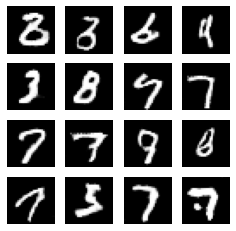

iter : 8000[D손실 : 0.4743371307849884], [정확도 : 77.34375] [G손실 : 2.123598098754883]


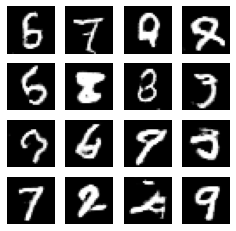

iter : 9000[D손실 : 0.389303058385849], [정확도 : 81.25] [G손실 : 2.421201705932617]


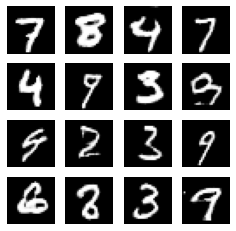

iter : 10000[D손실 : 0.37097011506557465], [정확도 : 83.203125] [G손실 : 2.159372329711914]


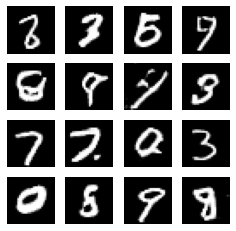

iter : 11000[D손실 : 0.36023128032684326], [정확도 : 83.984375] [G손실 : 2.3569045066833496]


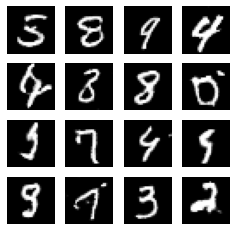

iter : 12000[D손실 : 0.4328417181968689], [정확도 : 78.125] [G손실 : 1.7988356351852417]


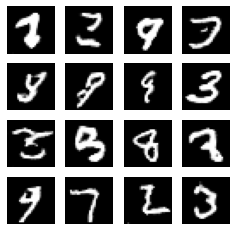

iter : 13000[D손실 : 0.35940825939178467], [정확도 : 84.765625] [G손실 : 2.2329747676849365]


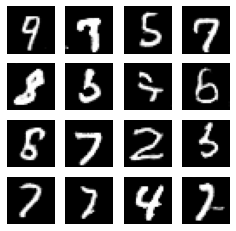

iter : 14000[D손실 : 0.3261979669332504], [정확도 : 84.375] [G손실 : 2.026599884033203]


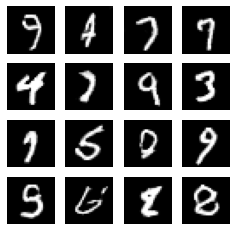

iter : 15000[D손실 : 0.3249767869710922], [정확도 : 85.15625] [G손실 : 2.4845566749572754]


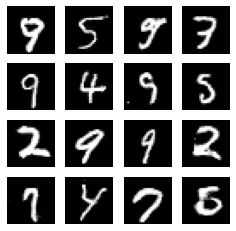

iter : 16000[D손실 : 0.3498758524656296], [정확도 : 82.8125] [G손실 : 2.264112710952759]


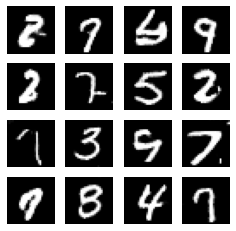

iter : 17000[D손실 : 0.3253121078014374], [정확도 : 83.59375] [G손실 : 2.347952127456665]


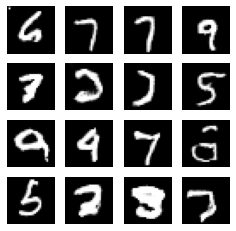

iter : 18000[D손실 : 0.3715789169073105], [정확도 : 81.640625] [G손실 : 1.9803575277328491]


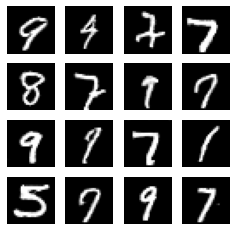

iter : 19000[D손실 : 0.3222654163837433], [정확도 : 84.375] [G손실 : 2.361217737197876]


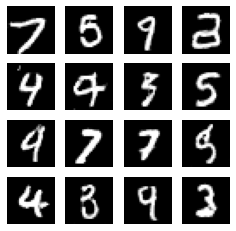

iter : 20000[D손실 : 0.3000306338071823], [정확도 : 85.546875] [G손실 : 2.4057114124298096]


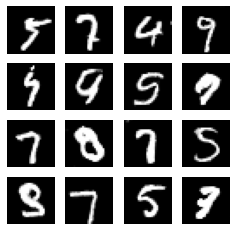

In [8]:
iterations = 20000
batch_size = 128
sample_interval = 1000

train(iterations, batch_size= batch_size , sample_interval= sample_interval)